### GIZ Initial Data Exploration
#### author: Emily Robitschek

Purpose: Before we build any model, we need to be able to take a look at the documents we have. This notebook includes functions to dive deep into the sections of a single document and the windows around the NDC keywords (in addition to giving a document overview). 

Some resources: 

#### papers mentioned in project proposal: 
https://medium.com/fiscalnoteworthy/citing-your-sources-79062248f468
https://www2.deloitte.com/us/en/insights/focus/cognitive-technologies/natural-language-processing-examples-in-government-data.html
https://documents1.worldbank.org/curated/en/634591516387264234/pdf/WPS8310.pdf

#### NLP related links: 
- https://spacy.io/usage/spacy-101
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675
- https://towardsdatascience.com/natural-language-processing-pipeline-decoded-f97a4da5dbb7

### Import libraries

In [1]:
import os
import glob
import time
import json
import codecs
import re

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict, Counter
import contractions
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy import displacy

nlp = spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

#from n_gram_correlation import NGramCorrelateSpacy

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

### Define helper functions for preprocessing

In [2]:
from datahelper import *
from nlppreprocess import *
from nlpanalysis import *

### Import data: Keywords from NDCs

In [3]:
#keywords from json file
json_keywords_SA_file = '../ndc_keywords/ndc_south_africa.json'
keywords_SA_dict = None
with open(json_keywords_SA_file, 'r') as f: 
    keywords_SA_dict = json.load(f)
keywords_SA_dict
ndc_dict = make_filtered_tokens_from_ndc(keywords_SA_dict)
ndc_dict

{'national adaption plan': ['national',
  'adaption',
  'plan',
  'nap',
  'sector',
  'nccrp',
  'vulnerable',
  'geographic',
  'vulnerability'],
 'climate change': ['climate',
  'change',
  'adaption',
  'program',
  'project',
  'resilience',
  'institutional',
  'capacity',
  'response',
  'budget',
  'reprioritisation',
  'development',
  'planner',
  'regulator',
  'practitioner',
  'geographical',
  'circumstance',
  'land',
  'use',
  'scheme',
  'authorisation',
  'system',
  'spatial',
  'management',
  'act',
  'spluma',
  'paris',
  'agreement'],
 'early warning': ['early',
  'warning',
  'system',
  'vulnerability',
  'need',
  'assessment',
  'weather',
  'service',
  'earth',
  'observation',
  'network',
  'academic',
  'community',
  'warn']}

### Import keywords to label topics around NDCs within the documents for policy coherence - these can be modified as desired, for instance a "mention_money" category was created from scratch and added to the csv file

In [4]:
sdg_ontology = pd.read_csv('../additional_resources/Ontology_final_modified.csv', sep=';')#, #skiprows=0)
sdg_ontology.head(20)

# uncomment for example keyword list for SDG1:  
#SDG1_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG1']['keyword'])

,keyword,clasification
0,"""bop"" countries",SDG1
1,absolute poverty,SDG1
2,bellagio principles,SDG1
3,child nutritional status,SDG1
4,counting marginalised children,SDG1
5,dimensions of inequality,SDG1
6,diseases of poverty,SDG1
7,economic marginalisation,SDG1
8,education poverty,SDG1
9,educational poverty,SDG1


### Import data: Policy-related documents to analyze

In [5]:
#here is the general folder with the different types of policy documents
policy_doc_folder = '../test_resources'
#get df of docs
policy_doc_df = read_docs_to_df(policy_doc_folder)
policy_doc_df.head()

,policy_doc_paths,policy_doc_name_clean
policy_doc_names,,
2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt,../test_resources/data/2nd National Biodiversi...,2nd National Biodiversity Strategy Action Plan...
Climate_Change_Bill (2018).txt,../test_resources/data/Climate_Change_Bill (20...,Climate_Change_Bill (2018)
Executive Summary-National Development Plan 2030.txt,../test_resources/data/Executive Summary-Natio...,Executive Summary-National Development Plan 2030
nationalprotectedareasexpansionstrategy2016ofsouthafrica.pdf_ocr.txt,../test_resources/data/nationalprotectedarease...,nationalprotectedareasexpansionstrategy2016ofs...
national-climate-change-response-white-paper.pdf_ocr.txt,../test_resources/data/national-climate-change...,national-climate-change-response-white-paper.p...


### Preprocess data

In [6]:
##lets take a look at the document from South Africa used in the example in the proposal first:
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

#can also simply specify the first or whichever document in the list by order: 
#(this will be helpful for future versions that involve more interrating over different documents)
#i=53
#doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
#doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
print(doc_name, doc_path)
tokens, token_list, sentences = preprocess_doc(doc_path)

#cut out long words for this particular document: (2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt) 
def make_window_text(tokens, max_length=30):
    filtered_for_length = [token.text.lower() for token in tokens if len(token) < max_length]
    text_for_windows = ' '.join(filtered_for_length)
    window_tokens = nlp(text_for_windows)
    return window_tokens

tokens = make_window_text(tokens, max_length=25)

2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt ../test_resources/data/2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt


#### The token object: 
The tokens have all sorts of useful information association with them, for instance their positions (in token.idx) which we can use these later to define windows. See below for example.

In [7]:
for token in token_list[:20]:
    print (token, token.idx)

environmental 0
affairs 14
Department 22
: 32
Environmental 34
Affairs 48
REPUBLIC 56
OF 65
SOUTH 68
AFRICA 74
y 81
South 83
Africa 89
’s 95
24 98
National 101
Biodiversity 110
Strategy 123
and 132
Action 136


We can see from above that the tokens need to be filtered and it might be useful if the words are all made lowercase and the words are lemmatized so the different forms of a word are recognized as the same thing

### Note: we didn't end up using the filtered tokens for some of the methods, but we tried doing some LDA and the intial results weren't great, but that sort of method requires more text preprocessing like in the filtered tokens 

In [8]:
filtered_tokens = filter_modify_tokens(tokens)
print('These are some of the filtered tokens: ', filtered_tokens[0:10])

These are some of the filtered tokens:  environmental affair department environmental affairs republic south africa y south


### Find most common (and unique) words

In [9]:
# Remove stop words and punctuation symbols
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
# 5 commonly occurring words with their frequencies
common_words = word_freq.most_common(30)
print(common_words)

# Unique words
#unique_words = [word for (word, freq) in word_freq.items() if freq == 1]
#print (unique_words)

[('biodiversity', 836), ('development', 326), ('national', 318), ('|', 284), ('south', 253), ('management', 243), ('area', 240), ('nbsap', 216), ('dea', 215), ('conservation', 210), ('ecosystem', 210), ('africa', 200), ('sector', 193), ('include', 190), ('specie', 175), ('plan', 166), ('priority', 163), ('environmental', 159), ('strategy', 159), ('support', 155), ('department', 150), ('sanbi', 144), ('protect', 137), ('ecological', 117), ('infrastructure', 115), ('resource', 115), ('programme', 114), ('policy', 114), ('provincial', 114), ('act', 112)]


### Make some plots of the NDC/Thematic key words

Graphing the occurences of national adaption plan words in the document


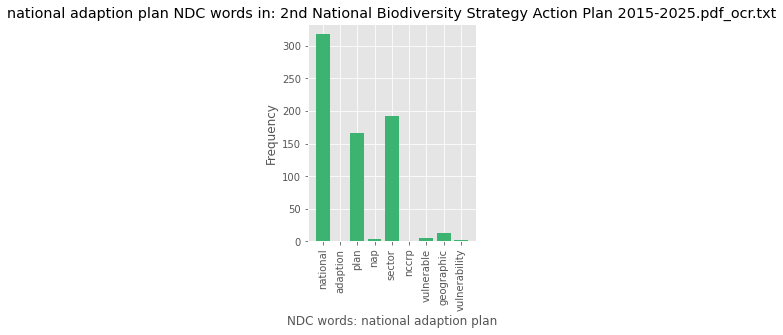

Graphing the occurences of climate change words in the document


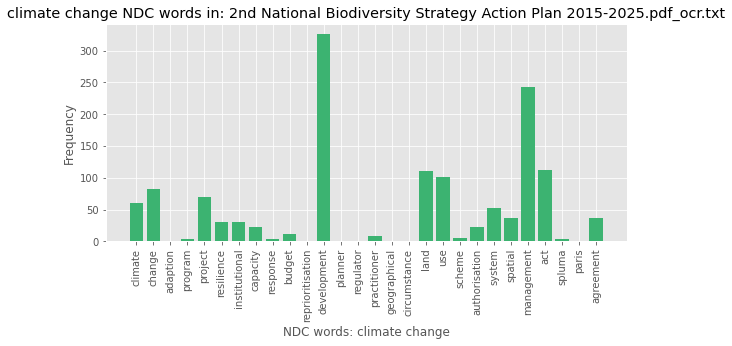

Graphing the occurences of early warning words in the document


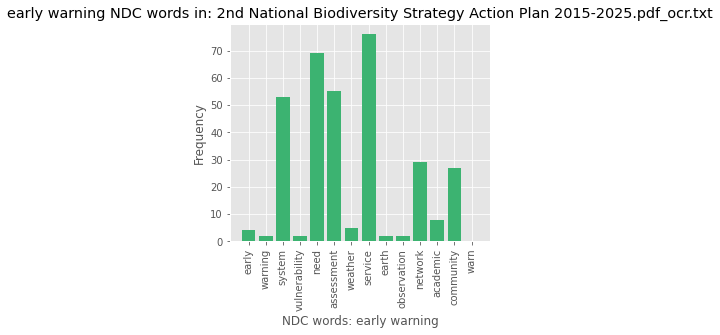

In [10]:
#just to test - need to modularise/make more reproducible and tailor output to be useful across documents
#could also link this back to the df of the documents to output a table with some summary metrics for keywords 
#in each document of interest

graphs_folder = '../../outputs/bar_charts/'    
    
for key in ndc_dict.keys(): 
    print("Graphing the occurences of %s words in the document" % key)
    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

### Lets take a closer look at the climate change NDC keywords

### Where do these words appear in the document?

#### Make dataframe for easy graphing

In [11]:
def make_ndc_keyword_tidy_df_from_dict(key, ndc_dict, col_group_name='NDC'):
    """From the NDC dictionary (ndc_dict), makes a df for the category (key) of interest"""
    ndc_df = pd.DataFrame({'keyword': ndc_dict[key], 
                       col_group_name: key})
    return ndc_df

def stack_tidy_ndc_dfs(ndc_dict, col_group_name='NDC'):
    """Stacks the dfs from the make_ndc_keyword_tidy_df_from_dict function, and creates a 
    category column (named with col_group_name) for which NDC category each word belongs to."""
    ndc_df = pd.DataFrame()
    for key in ndc_dict.keys():
        ndc_df_add = make_ndc_keyword_tidy_df_from_dict(key, ndc_dict, col_group_name)
        ndc_df = pd.concat([ndc_df, ndc_df_add], axis=0)
    return ndc_df

def make_ndc_i_tidy_df(ndc_dict, tokens, col_group_name):
    """Creates a df of the spacy indexs in the document that match each keyword"""
    ndc_idx_df = pd.DataFrame()
    for key in ndc_dict.keys(): 
        ndc_idx_df_to_add = pd.DataFrame({col_group_name: key,
                                          #('%s word_index'%(key)): [token.idx for token in tokens if token.text in ndc_dict[key]],
                                          'word_index': [token.i for token in tokens if token.text in ndc_dict[key]]})
        ndc_idx_df = pd.concat([ndc_idx_df, ndc_idx_df_to_add], axis=0)
    return ndc_idx_df

# lets apply: 
ndc_df = stack_tidy_ndc_dfs(ndc_dict, col_group_name='NDC')
print(ndc_df.head())

ndc_i_df = make_ndc_i_tidy_df(ndc_dict, tokens, col_group_name='NDC')
ndc_i_df.index = ndc_i_df.NDC.copy()
ndc_i_df.head()

#if want to include the letter index as well for the window (this was the original index scheme 
#used for the presentation and other results)
ndc_i_df['doc_position_idx_index'] = [tokens[int(i)].idx for i in list(ndc_i_df['word_index'])]
ndc_i_df.head()

    keyword                     NDC
0  national  national adaption plan
1  adaption  national adaption plan
2      plan  national adaption plan
3       nap  national adaption plan
4    sector  national adaption plan


,NDC,word_index,doc_position_idx_index
NDC,,,
national adaption plan,national adaption plan,15,103
national adaption plan,national adaption plan,20,145
national adaption plan,national adaption plan,30,195
national adaption plan,national adaption plan,35,237
national adaption plan,national adaption plan,99,665


## Part I: Finding NDC keywords in the document
Three methods: 
    
    1) uses the make_filtered_tokens_from_ndc method to create single lemmatized keywords that are preprocessed in the same way as the document text for flexible matching of single words (matches "plan" and "plans" and "planned" from original document for example). 

    2) uses the dictionary from the json file to find exact matches to the terms with the spacy Phrase matcher, which expands the searching to multiple word phrases from the input document. The entity matching, also addes functionality for easy and pretty visualization. 

    3) applies the token correlator to the NDC keywords from the json file for a particular topic to expand the keyword search terms based on the terms from the NDCs

### METHOD 1: Finding and matching single word stems from the NDC keywords to words in the document

In [12]:
NDC_topic = 'climate change'
#the indices for the NDC keywords are found using this scheme:  (https://spacy.io/api/token)
#using .i to get the word position of the token, and .idx gets the character offset of the token within the parent document.
ndc_climate_idxs = [token.i for token in tokens if token.text in ndc_dict[NDC_topic]] 
print(ndc_climate_idxs[:20])

#We can see what words they are with the following code: 
ndc_climate_words_in_doc = [token.text for token in tokens if token.text in ndc_dict[NDC_topic]]
print(ndc_climate_words_in_doc[:20])

#They indexes can be displayed in a nice way with the function to make the ndc_idx_df
ndc_i_df['doc_position_idx_index'] = [tokens[int(i)].idx for i in list(ndc_i_df['word_index'])]
ndc_i_df.head()
ndc_i_df[ndc_i_df['NDC'] == NDC_topic].head(10)

[57, 84, 141, 194, 281, 293, 314, 377, 384, 409, 414, 429, 522, 624, 816, 855, 867, 872, 909, 919]
['development', 'development', 'development', 'development', 'management', 'development', 'resilience', 'management', 'development', 'management', 'use', 'institutional', 'development', 'management', 'agreement', 'agreement', 'climate', 'act', 'development', 'management']


,NDC,word_index,doc_position_idx_index
NDC,,,
climate change,climate change,57,375
climate change,climate change,84,555
climate change,climate change,141,912
climate change,climate change,194,1267
climate change,climate change,281,1821
climate change,climate change,293,1901
climate change,climate change,314,2038
climate change,climate change,377,2412
climate change,climate change,384,2463


### METHOD 2: Finding exact matches to the terms with the spacy Phrase matcher and entity labelling (also allows nice visualizations of the text with the labelled terms with displacy)

In [13]:
def label_ndc_spans(ndc_keywords, doc):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    return entity_labels, doc

def make_ndc_i_df_from_spans(ndc_keywords, labelled_doc): 
    """ndc_keywords is the ndc keyword dictionary and the labelled_doc is the one labelled with the spans of NDC keywords. 
    idx here refers to the start word token index of the spans."""
    ndc_idx_df = pd.DataFrame()
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label) 
        ndc_idx_df_to_add = pd.DataFrame({'NDC': entity_reference,
                                          ('word'): [ent.text for ent in labelled_doc.ents if ent.label_ == entity_label],
                                          'word_index': [ent.start for ent in labelled_doc.ents if ent.label_ == entity_label]})
        ndc_idx_df = pd.concat([ndc_idx_df, ndc_idx_df_to_add], axis=0)
    return ndc_idx_df 

def label_keyword_spans(keyword_df, doc, topic_column='clasification'):
    """This function is similar to the function used to label the NDC spans in the document, but it labels all the keywords for the topics in the keyword df (in this example - mostly SDG topic keywords)
    keyword_df is a pandas df, doc should be the document already labeled with ndc entities so both labels are kept."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through the keyword categories in the columns of the keyword_df to create labels for the matching
    entity_labels = []
    topics = list(keyword_df[topic_column].value_counts().index)
    for topic in topics:
        entity_labels.append(topic)
        keywords = list(keyword_df[keyword_df[topic_column]==topic]['keyword'])
        #print(keywords)
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(topic, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    return entity_labels, doc

def label_ndc_keyword_spans(ndc_keywords, doc, keyword_df, topic_column='clasification'):
    """combined version of label_ndc_spans and label_keyword_spans to only do one matching step"""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    ndc_entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        #print(entity_label)
        ndc_entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    #iterate through the keyword categories in the columns of the keyword_df to create labels for the matching
    topics = list(keyword_df[topic_column].value_counts().index)
    for topic in topics:
        keywords = list(keyword_df[keyword_df[topic_column]==topic]['keyword'])
        #print(keywords)
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(topic, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    return ndc_entity_labels, topics, doc

#Heres an example of how it works with just one sentence of text with keywords the finder should discover!
test_doc = "climate change resilience is very important to south africa and we need an adaption program and adaption projects to deal with it and increase institutional capacity. Our practices need to change to protect the planet. Biodiversity should be protected and health systems need to also be improved to fight against infectious diseases like malaria."
entity_labels, ndc_labelled_doc = label_ndc_spans(keywords_SA_dict, nlp(test_doc))
displacy.render(ndc_labelled_doc, style='ent')
ndc_i_df_spans = make_ndc_i_df_from_spans(keywords_SA_dict, ndc_labelled_doc)

#entity_labels, kw_labelled_doc = label_keyword_spans(sdg_ontology, ndc_labelled_doc)
#displacy.render(kw_labelled_doc, style='ent')

ndc_entity_labels, keyword_topics, all_labelled_doc = label_ndc_keyword_spans(keywords_SA_dict, nlp(test_doc), sdg_ontology)
displacy.render(all_labelled_doc, style='ent')

#if want to include the letter index as well for the window
ndc_i_df_spans['doc_position_idx_index'] = [tokens[int(i)].idx for i in list(ndc_i_df_spans['word_index'])]
ndc_i_df_spans.head()

,NDC,word,word_index,doc_position_idx_index
0,climate change,climate change,0.0,0
1,climate change,resilience,2.0,22
2,climate change,adaption program,13.0,97
3,climate change,adaption projects,16.0,112
4,climate change,institutional capacity,24.0,162


In [14]:
# Apply to actual policy document
#ndc_category_labels, ndc_labelled_doc = label_ndc_spans(keywords_SA_dict, tokens)
#sdg_keyword_labels, kw_labelled_doc = label_keyword_spans(sdg_ontology, ndc_labelled_doc)

ndc_entity_labels, keyword_topics, all_labelled_doc = label_ndc_keyword_spans(keywords_SA_dict, tokens, sdg_ontology)
displacy.render(all_labelled_doc[600:1000], style='ent')

#the indices for the NDC keywords are found using this scheme: 
ndc_climate_idxs_from_span = [ent.start for ent in all_labelled_doc.ents if ent.label_ == (NDC_topic + ' NDC')]
print(ndc_climate_idxs_from_span[:20])

#We can see what words they are with the following code: 
ndc_climate_words_in_doc_from_span = [ent.text for ent in all_labelled_doc.ents if ent.label_ == (NDC_topic + ' NDC')]
print(ndc_climate_words_in_doc_from_span[:20])

#They can be displayed in a nice way with the function to make the ndc_i_df_from_the_spans:
ndc_i_df_spans = make_ndc_i_df_from_spans(keywords_SA_dict, all_labelled_doc)
ndc_i_df_spans[ndc_i_df_spans['NDC'] == NDC_topic].head(20)

#if want to include the letter index as well for the window
ndc_i_df_spans['doc_position_idx_index'] = [tokens[int(i)].idx for i in list(ndc_i_df_spans['word_index'])]
ndc_i_df_spans.head()

[141, 194, 293, 314, 384, 522, 909, 1031, 1057, 1064, 1151, 1182, 1201, 1280, 1283, 1293, 1346, 1453, 1473, 1491]
['development', 'development', 'development', 'resilience', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development', 'development']


,NDC,word,word_index,doc_position_idx_index
0,national adaption plan,nap,1354,9119
1,national adaption plan,nap,7345,46014
2,national adaption plan,nap,27481,172204
0,climate change,development,141,912
1,climate change,development,194,1267


In [15]:
##can see some of the rendered areas with NDC keywords and other topic keywords with the following command. One limitation or advantage of using the phrase matcher is that each found span can only be counted for one category whereas the patterns found using re might vary slightly due to the different rules
for e in all_labelled_doc.ents[200:300]:
    if e.label_ == (NDC_topic + ' NDC'): 
        displacy.render(all_labelled_doc[e.start-20:e.end+20], style='ent')

### Method 3: Apply the token correlator to the NDC keywords from the json file for a particular topic to expand the keyword search terms based on the terms from the NDCs

In [16]:
### insert code here - this method was applied experimentally at the corpus level for instance

## PART II: Defining windows around NDC words 
### To systematically identify consistent windows around the NDC words we can do this manually with a particular word number

In [17]:
def return_window_i(ndc_word_index, tokens, size=20):
    """size is the number of words to include on either side of the NDC keyword whose position is given by the ndc_word_index. 
    The tokens are the original tokens in the document"""
    lower_limit = ndc_word_index - size
    upper_limit = ndc_word_index + size
    token_indices = [token.i for token in tokens]
    window_tokens = tokens[(ndc_word_index-size):(ndc_word_index+size)] 
    return lower_limit, upper_limit, window_tokens

def return_window_idx(ndc_word_index, tokens, size=100):
    """Uses the .idx positions of the start of the invidual NDC words in the document to define the windows."""
    lower_limit = ndc_word_index - size
    upper_limit = ndc_word_index + size
    token_idxs = [token.idx for token in tokens]
    window_token_list = []
    #print('The window is ', lower_limit, upper_limit)
    for index, idx in enumerate(token_idxs):
        if (idx >= lower_limit) and (idx <= upper_limit):
            window_token_list.append(tokens[index])
        else:
            pass
    text_for_windows = ' '.join(list(token.text for token in window_token_list))
    window_tokens = nlp(text_for_windows)
    return lower_limit, upper_limit, window_tokens

#example
test_index=1988 #(each window may include multiple keywords because they may be close to each other)
window_size = 40
lower_limit, upper_limit, window_tokens = return_window_i(test_index, all_labelled_doc, size=window_size)
displacy.render(window_tokens, style='ent') 

#### No matter what method we use to find the keywords, some of the keywords will naturally occur very close together and we dont want to visualize each window more than once so for now we will filter the NDC word positions in the document for those that will fall within the same word window. (May eventually want to do this differently to prioritize windows with many keywords). 

In [18]:
#filtering using word positions in document: 
def filter_i_for_overlap(word_idxs, min_dist=20):
    """Min distance is the minimum number of words that should seperate the NDC keyword whose positions are given in word_idxs 
    in order to create a seperate window from that index. It should be at least equal to the size value from the return_window_i function"""
    distance_btwn_idxs = [(word_idxs[i+1]-word_idxs[i]) for i in range(0, len(word_idxs)-1)]
    print(distance_btwn_idxs[:200])
    filtered_idxs = []
    for index, distance in enumerate(distance_btwn_idxs):
        #print('index:', index, 'distance', distance)
        if (distance >= min_dist):
            filtered_idxs.append(word_idxs[index])
        else:
            pass
    print("The number of times the idx words were found was: ", len(word_idxs), "\n", 
          "The number of idx words seperated by at least the min_distance was : ", len(filtered_idxs))
    return filtered_idxs

def filter_idx_for_overlap(idxs, min_dist):
    distance_btwn_idxs = [(idxs[i+1]-idxs[i]) for i in range(0, len(idxs)-1)]
    print(distance_btwn_idxs[:20])
    filtered_idxs = []
    for index, distance in enumerate(distance_btwn_idxs):
        if (distance >= min_dist):
            filtered_idxs.append(idxs[index])
        else:
            pass
    print("The number of times the idx words were found was: ", len(idxs), "\n", 
          "The number of idx words seperated by at least the min_distance was : ", len(filtered_idxs))
    return filtered_idxs
    
#filtering using letter positions in document (used with the NDC keywords from METHOD 1 for the presentation for Hack4Good, which is a more permissive search.)
#however, using word based indexing is probably more robust to error and easier unless you want to compare the positions of keywords found by re and spans found by spacy directly
ndc_climate_idxs_from_doc_pos = list(ndc_i_df[ndc_i_df['NDC'] == NDC_topic]['doc_position_idx_index'])
idx_for_window_from_doc_pos = filter_idx_for_overlap(idxs=ndc_climate_idxs_from_doc_pos, min_dist=200)

# Can see how the choice of search method changes the NDC associated words found, and we would expect the span searching which is more exact to find fewer results overall: 
#filtering using word positions in document (used with the NDC keywords from METHOD 2 to show difference with METHOD 1.)
idx_for_window = filter_i_for_overlap(ndc_climate_idxs_from_span, min_dist=40)

[180, 357, 355, 554, 80, 137, 374, 51, 167, 42, 104, 595, 577, 1096, 282, 83, 34, 269, 81, 53]
The number of times the idx words were found was:  1238 
 The number of idx words seperated by at least the min_distance was :  432
[53, 99, 21, 70, 138, 387, 122, 26, 7, 87, 31, 19, 79, 3, 10, 53, 107, 20, 18, 10, 14, 3, 21, 5, 69, 4, 10, 133, 129, 40, 28, 58, 17, 53, 249, 73, 15, 8, 44, 11, 97, 70, 126, 110, 28, 47, 10, 46, 33, 19, 13, 323, 181, 36, 47, 95, 43, 438, 49, 88, 12, 92, 611, 68, 210, 1383, 882, 316, 15, 172, 60, 455, 386, 26, 6, 50, 21, 15, 18, 28, 23, 19, 139, 3, 11, 61, 255, 48, 99, 8, 19, 320, 760, 35, 17, 79, 16, 13, 27, 22, 39, 22, 9, 63, 50, 243, 98, 33, 101, 63, 7, 13, 7, 44, 36, 197, 19, 12, 18, 156, 106, 37, 452, 588, 42, 77, 229, 612, 15, 5, 37, 183, 52, 139, 210, 4, 51, 178, 7, 128, 21, 8, 62, 159, 224, 87, 20, 56, 232, 158, 110, 28, 47, 10, 46, 33, 19, 13, 150, 39, 50, 180, 462, 100, 253, 76, 54, 298, 125, 414, 557, 249, 915, 111, 50, 11, 147, 52, 26, 400, 13, 27, 28

## PART III: Characterizing the topics mentioned and text context of windows around NDC words
### This supervised approach based on pre-defined keywords with different topic categories (from the SDG Ontology uploaded at the beginning of this notebook) can be complemented with other methods in the future like LDA

#### example using the spans and the word indexs from the token.i attributes

In [19]:
def make_sdg_df(sdg_list, sdg_ontology, text):
    df_sdg = pd.DataFrame()
    for sdg in list(sdg_list):
        sdg_keywords = list(sdg_ontology[sdg_ontology['clasification']==sdg]['keyword'])
        #print(sdg)
        df_sdg_to_add = find_patterns_df(sdg_keywords, text, topic_name=sdg)
        df_sdg = pd.concat([df_sdg, df_sdg_to_add])
    return df_sdg

#look at SDGs across document/at document level
sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

def find_patterns_df(pattern_list, text, topic_name):
    pattern_locations = []
    pattern_num = []
    for pattern in pattern_list:
        #print(pattern)
        re.findall(pattern, text, flags=0)
        #pattern_locations = [(m.start(0), m.end(0)) for m in re.finditer(pattern, text)] #if want start and end
        locations = [m.start(0) for m in re.finditer(pattern, text)]
        pattern_locations.append(locations)
        pattern_num.append(int(len(locations)))
    #print(pattern_locations)
        #if len(pattern_locations) > 0: 
        #    print(pattern, len(pattern_locations), pattern_locations)
    return pd.DataFrame({'sdg_topic': topic_name,
                         'sdg_keywords': pattern_list,
                         'sdg_keywords_num': pattern_num,
                         'sdg_keyword_locations': pattern_locations})

window_size = 20
count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window_i(index, all_labelled_doc, size=window_size)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

141
['$', 'eu', 'development']
194
['diversity', 'biodiversity', 'policies', '$', 'development policies', 'government', 'policy', 'development']
314
['wellbeing', 'infrastructure', 'diversity', 'ecological infrastructure', '$', 'policies', 'biodiversity', 'job creation']
384
['diversity', 'development', 'indigenous', '$', 'work', 'biodiversity', 'workforce']
522
['$', 'development']
909
['diversity', 'biodiversity', 'finance', 'finance', '$', 'stem', 'development']
1064
['environment', 'development', 'tourism', '$', 'fisheries', 'fisherie', 'forestry', 'education', 'forest', 'basic education']
1201
['development', 'industry', 'water', 'trade', '$', 'rural development', 'water and sanitation', 'stem', 'rural', 'rural development']
1293
['development', 'institutions', '$', 'diversity', 'stem', 'higher education', 'education', 'government', 'biodiversity', 'land']
1346
['land', 'development', 'work', 'minerals', 'eu', '$']
1544
['environment', 'development', 'work', '$', 'marine', 'commun

['conservation areas', 'biodiversity', 'climate change', 'protected area', 'targets', '$', 'stem', 'economic benefits', 'climate', 'diversity']
18133
['rural', 'rural development', '$', 'biodiversity', 'job creation', 'economy', 'development', 'rural development', 'wellbeing', 'diversity']
18209
['$', 'protected area', 'rent', 'development', 'protected areas']
18263
['$', 'development']
18561
['city', 'biodiversity', 'diversity', 'authority', '$', 'land']
18686
['diversity', '$', 'ngos', 'climate', 'economic benefits', 'biodiversity']
19100
['funding', 'development', '$', 'fund']
19657
['diversity', 'biodiversity', 'fund', 'rural', 'communities', 'development', 'economic growth', '$', 'growth']
19906
['diversity', 'biodiversity', 'economy', 'development', 'poverty alleviation', 'economic development', 'economic development', 'poverty alleviation', '$', 'poverty']
20821
['ecological infrastructure', 'infrastructure', 'land', 'society', 'diversity', 'wetlands', '$', 'ngos', 'biodiversity

['$', 'development', 'environment']
37675
['diversity', 'biodiversity', 'cost', 'finance', 'finance', '$', 'development']
38317
['$', 'development', 'targets']
38437
['protected areas', 'protected area', 'work', 'development', '$', 'rural', 'biodiversity', 'rural development', 'infrastructure', 'ecological infrastructure']
38930
['diversity', '$', 'climate change', 'communities', 'climate', 'biodiversity', 'development']
39086
['biodiversity', 'diversity', 'rent', '$', 'development', 'environment']
39321
['$', 'development', 'policy', 'stem']
39394
['diversity', 'biodiversity', '$', 'who', 'development']
39492
['diversity', 'biodiversity', 'workforce', 'work', 'rent', '$', 'development']
39564
['diversity', 'fund', '$', 'development', 'biodiversity', 'stem', 'occupation']
40512
['targets', 'rural development', 'biodiversity', 'protected areas', '$', 'protected area', 'rural', 'sdg', 'job creation', 'development']
40706
['livelihoods', 'rural development', '$', 'development', 'job creat

In [20]:
summary_sdg_df.head()

,sdg_kw_141,sdg_kw_194,sdg_kw_314,sdg_kw_384,sdg_kw_522,sdg_kw_909,sdg_kw_1064,sdg_kw_1201,sdg_kw_1293,sdg_kw_1346,...,sdg_kw_40706,sdg_kw_40779,sdg_kw_40837,sdg_kw_40913,sdg_kw_41065,sdg_kw_41921,sdg_kw_43053,sdg_kw_43334,sdg_kw_43561,sdg_kw_43654
sdg_topic,,,,,,,,,,,,,,,,,,,,,
SDG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG10,1,1,0,1,1,1,2,2,3,1,...,1,1,3,1,2,3,1,1,2,1
SDG11,0,0,0,1,0,0,0,2,0,0,...,2,0,0,0,0,0,0,0,0,0
SDG12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Can create a heatmap visualization to where the topics are rows and the columns are each window (where the columns on the left are from the start of the document and the ones on the right are from the end). The number of keyword mentions found for each topic within each window are used to fill in the heatmap and color it (showing results from METHOD 2 of labelling NDC words

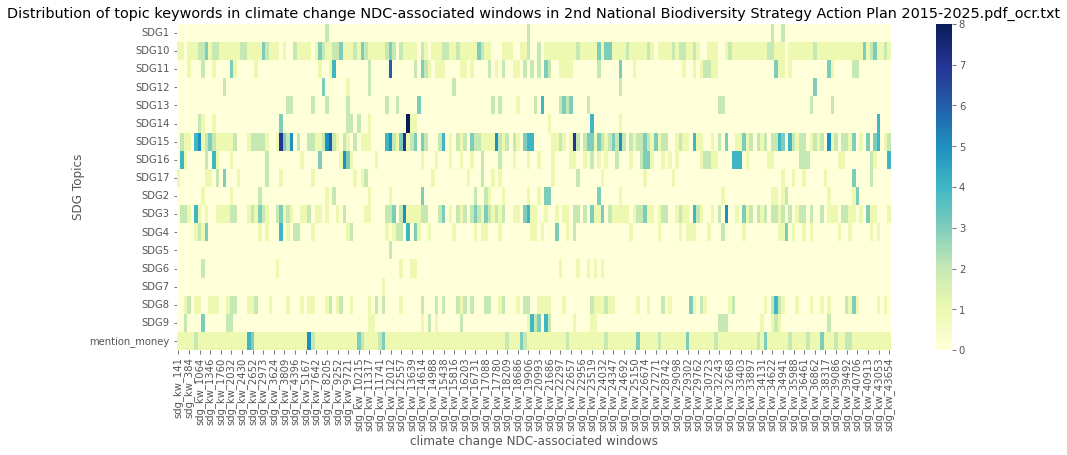

In [21]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across all windows v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### can filter the heatmap visualization to focus on columns (each representing an NDC window) with the most topic keyword mentions

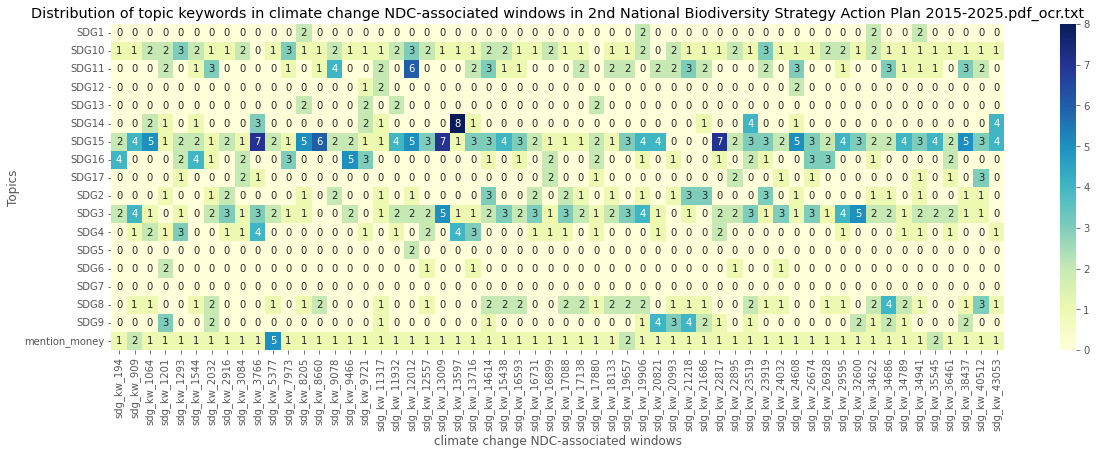

In [22]:
summary_sdg_df_filtered = summary_sdg_df.loc[:, (summary_sdg_df.sum() >= 10)] #filter for windows with at least 15 topic keywords
plt.figure(figsize=(20, 6))
ax = sns.heatmap(summary_sdg_df_filtered, #can show all windows with summary_sdg_df
                 annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows with greater than 15 keywords v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### coherence and relevance (with NDC positions from METHOD 2)

8.133663366336634
The relevance score for 2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt is 0.24392041267501843
The coherence score for 2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt is 8.133663366336634


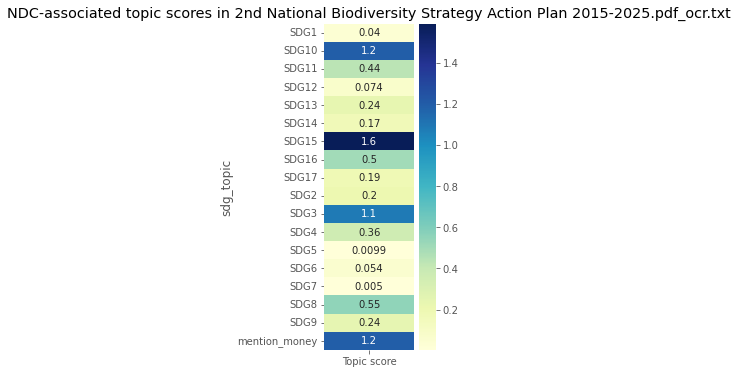

In [24]:
### compute coherence by summing the keywords that appear in NDC windows across categories (maybe introduce normalization and weighting by categories in the future)
coherence_for_frame = summary_sdg_df.sum(axis=1)/len(summary_sdg_df.columns)
coherence_df = coherence_for_frame.to_frame().rename(columns={0:"Topic score"})
coherence_score = coherence_df['Topic score'].sum()
print(coherence_score)
coherence_df

### compute relevance by estimating the number of ndc_climate_idxs per sentence in the document
relevance_score = len(ndc_climate_idxs_from_span)/len(sentences) #example using the number of NDC mentions with METHOD 2 
print('The relevance score for %s is' % doc_name , relevance_score)
print('The coherence score for %s is' % doc_name , coherence_score)

#print a summary of the SDG words found in the windows: 
plt.figure(figsize=(2, 6))
ax = sns.heatmap(coherence_df, 
                 annot=True, #fmt="d", 
                 cmap="YlGnBu")

#plt.xlabel("climate change NDC-associated windows")
#plt.ylabel("Topics")
title = ("NDC-associated topic scores in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across document normalized by number of windows v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

#### In this visualization for instance we can understand that there are on average 1.6 SDG15 related words per 40 word window and about 1.2 mentions of money per 40 word window near an NDC phrase for this document

In [25]:
#example of rendered windows (the NDC word/term will always be present at the word index associated with the window, but sometimes it is not properly labelled in the render, 
#probably due to how the span labelling function works in spacy and doesnt allow overlap, whereas re will double count terms if they appear in different categories): 
indices_for_render = [3766, 5377, 13597]#idx_for_window
for i in indices_for_render: 
    print("The NDC word for the window is ", all_labelled_doc[i])
    window_tokens = return_window_i(i, all_labelled_doc, size=window_size)[2]
    displacy.render(window_tokens, style = "ent", jupyter = True)

The NDC word for the window is  resilience


The NDC word for the window is  development


The NDC word for the window is  development


### Summary of topic (mostly SDG) keywords at the document level

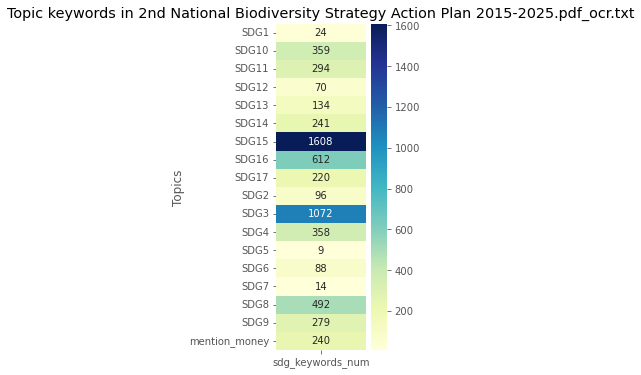

In [26]:
document_text = ' '.join([token.text for token in tokens])
df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("%s"% doc_name)})

plot_folder = '../../outputs/heatmaps/'
#print a summary of the SDG words found: 
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg.to_frame()
#doc_summary_sdg.to_frame()
plt.figure(figsize=(2, 6))
ax = sns.heatmap(doc_summary_sdg.to_frame(), 
                 annot=True, fmt="d", 
                 cmap="YlGnBu")

#plt.xlabel("climate change NDC-associated windows")
plt.ylabel("Topics")
title = ("Topic keywords in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across document v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### can also see specific keywords mentioned the most in the document, not just the counts: 

In [27]:
df_sdg_sorted  = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:15])

['diversity',
 'biodiversity',
 'development',
 'stem',
 'environment',
 'work',
 'land',
 'infrastructure',
 'government',
 'protected area',
 'ecological infrastructure',
 'water',
 'activities',
 'policy',
 'economy']

## Apply topic keyword searching within the windows around NDC words to localize the topic searching to those areas of the document (using Method 1 and idx positions (similar to results from presentation)

In [28]:
#may want to increase the min_distance/set it as a function of window size
window_size = 200
min_dist = 100
idx_for_window = idx_for_window_from_doc_pos

In [29]:
count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window_idx(index, tokens, size=window_size)[2] #window_tokens_overall
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

555
['environment', 'united nations', 'development', 'biodiversity', 'diversity', '$', 'government']
912
['$', 'eu', 'development', 'environment']
1267
['diversity', 'biodiversity', 'policies', '$', 'development policies', 'government', 'policy', 'development']
2038
['biodiversity', 'ecological infrastructure', 'rural', 'policies', '$', 'rural development', 'rural development', 'job creation', 'infrastructure', 'development']
2776
['$', 'indigenous']
3371
['diversity', 'biodiversity', 'work', 'development', '$']
3948
['stem', 'diversity', 'policy', '$', 'biodiversity', 'biodiversity conservation']
5044
['work', '$', 'targets', 'stakeholders']
5443
['diversity', '$', 'climate', 'demography', 'biodiversity', 'stem']
5959
['diversity', 'biodiversity', 'training', 'stem', '$', 'organisation', 'society', 'convention on biological diversity', 'community based', 'authority']
6622
['governance', 'rural', '$', 'rural development', 'rural development', 'forest', 'environment', 'development', 'fo

['environment', 'biodiversity', 'diversity', 'natural resource', 'natural resources', '$', 'institutions']
51018
['environment', 'natural resource', 'distribution', 'natural resources', '$', 'development', 'policies']
51720
['work', 'diversity', 'biodiversity', 'environment', 'land', 'water', 'energy', 'wetlands', '$', 'natural resource']
52475
['biodiversity', 'diversity', 'policy', 'agenda', '$']
52891
['protected areas', 'protected area', 'diversity', 'authority', '$', 'stem', 'biodiversity']
53398
['land', 'authority', 'diversity', 'unesco', 'environment', 'biodiversity', '$']
54203
['protected areas', 'protected area', 'work', 'natural resource', 'biodiversity', 'tourism', 'ecotourism', 'natural resources', '$', 'development']
55013
['water', 'health', 'stem', 'biodiversity', 'infrastructure', 'diversity', 'ecological infrastructure', '$']
55233
['water', 'infrastructure', 'ecological infrastructure', 'fisheries', 'forest', '$', 'forestry', 'health', 'stem', 'fisherie']
55721
['bi

['environment', 'biodiversity', 'diversity', 'agenda', '$']
100346
['biodiversity', 'diversity', 'rural development', 'infrastructure', 'policies', 'job creation', 'development', 'rural development', 'rural', 'ecological infrastructure']
100892
['diversity', 'biodiversity', 'indigenous', 'work', '$', 'workforce']
102091
['$', 'development', 'targets']
102790
['diversity', 'biodiversity', 'economy', 'rural', '$']
103094
['conservation areas', 'biodiversity', '$', 'protected area', 'stem', 'policies', 'job creation', 'indigenous', 'work', 'development']
103612
['activities', 'rural', 'land', 'society', '$', 'economy', 'diversity', 'ecological infrastructure', 'agenda', 'biodiversity conservation']
103978
['biodiversity', 'diversity', 'development', 'rural development', 'job creation', 'rural', 'activities', '$', 'stem', 'livelihood']
104385
['diversity', 'development', 'biodiversity', 'government', '$', 'development planning']
105138
['development', 'partnerships', 'partnership', '$', 'i

['diversity', 'biodiversity', 'climate change', 'climate', 'fisheries', 'industry', '$', 'fisherie']
146837
['biodiversity', 'diversity', 'fisheries', 'fisherie', 'policies', '$', 'economy', 'industry', 'development policies', 'green economy']
147216
['biodiversity', 'diversity', 'land degradation', 'climate change adaptation', '$', 'climate', 'activities', 'land', 'degradation', 'environment']
148041
['biodiversity', 'diversity', 'environment', 'municipalities', 'ngos', 'institutions', '$', 'organisation', 'stem']
148491
['diversity', 'biodiversity', 'development', '$', 'development planning', 'integration']
148828
['development', 'infrastructure', 'diversity', '$', 'biodiversity', 'stem', 'work']
150063
['biodiversity', 'work', 'diversity', 'integration', '$', 'land', 'development', 'water', 'aid', 'aid']
150365
['diversity', 'forest', 'biodiversity', 'forestry', 'development', 'work', '$']
150631
['development', 'forest', 'development planning', 'diversity', '$', 'money', 'governmen

['stem', 'marine', '$', 'water', 'ngos', 'distribution', 'environment', 'tax']
196901
['diversity', 'stem', 'indigenous', 'biodiversity', '$']
197331
['diversity', '$', 'stem', 'biodiversity', 'environment']
197703
['diversity', 'biodiversity', 'stem', 'health', '$']
199202
['$', 'ngos', 'development', 'tax', 'institutions', 'activities']
199784
['biodiversity', 'marine', 'diversity', '$', 'ngos', 'distribution', 'environment', 'land', 'fisheries', 'fisherie']
200986
['diversity', 'biodiversity', '$', 'infrastructure', 'policy', 'city']
201740
['diversity', 'biodiversity', 'infrastructure', '$', 'ecological infrastructure']
202555
['diversity', 'biodiversity', 'infrastructure', '$', 'ecological infrastructure']
203387
['biodiversity', 'diversity', 'stem', 'climate change', 'fruit', 'infrastructure', 'ecological infrastructure', '$', 'climate']
204540
['diversity', 'biodiversity', 'policy', 'infrastructure', '$', 'ecological infrastructure', 'wellbeing', 'human wellbeing', 'development'

['diversity', 'stem', 'biodiversity', 'fund', '$']
253590
['targets', 'sdg', 'sustainable development goal', 'sustainable development goals', '$', 'sustainable development goal', 'aichi targets', 'biodiversity', 'sdgs', 'diversity']
254311
['targets', 'rural development', 'rural development', 'work', 'aichi targets', 'stem', 'protected area', 'sdg', '$', 'protected areas']
255300
['job creation', 'livelihoods', 'society', 'ecological infrastructure', 'livelihood', '$', 'rural development', 'rural', 'development', 'infrastructure']
255638
['diversity', 'biodiversity', '$', 'development', 'stem']
255978
['development', 'diversity', '$', 'development planning', 'biodiversity']
256442
['diversity', 'biodiversity', '$', 'development', 'government', 'policy']
257324
['development', 'partnerships', 'who', 'partnership', 'workforce', 'stem', '$', 'delivery', 'institutions', 'diversity']
257796
['stem', 'diversity', '$', 'sdg', 'indigenous', 'biodiversity']
258183
['diversity', 'biodiversity', 

In [30]:
len(summary_sdg_df.columns)

432

### Can create a heatmap visualization to where the topics are rows and the columns are each window (where the columns on the left are from the start of the document and the ones on the right are from the end). The number of keyword mentions found for each topic within each window are used to fill in the heatmap and color it (SHOWING RESULTS FROM METHOD 1 of labelling NDC words

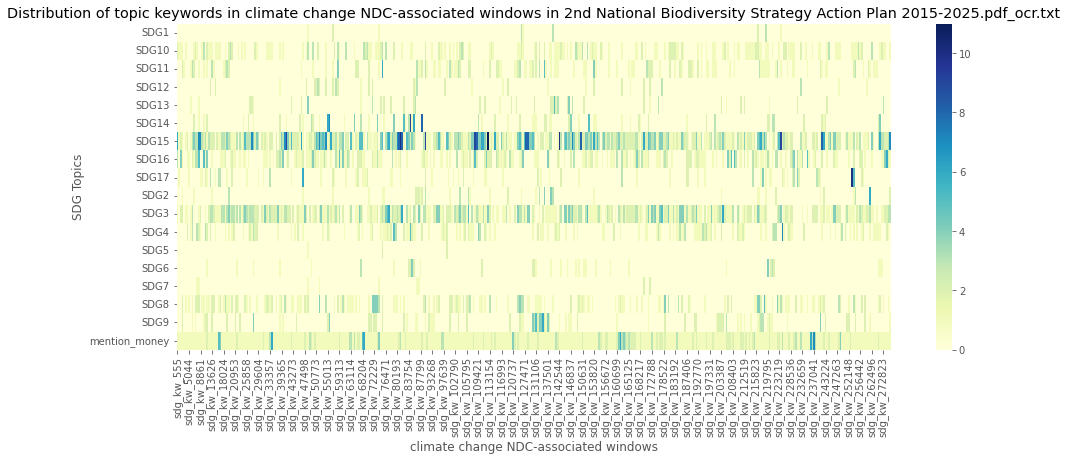

In [32]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across all windows v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### can filter the heatmap visualization to focus on one section of the document and not the whole thing and show the actual numbers of keywords in each window in that section

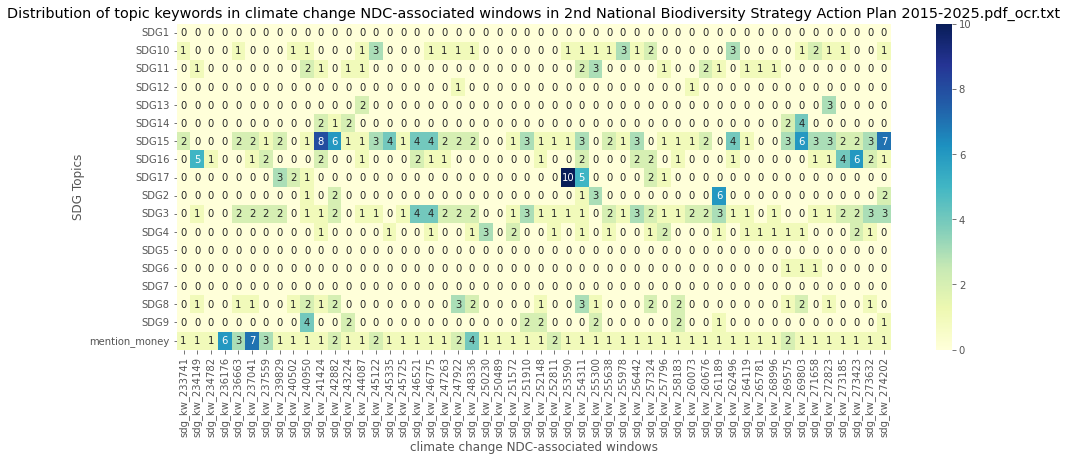

In [33]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df.iloc[:, 380:], #can show all windows with summary_sdg_df
                 annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows 40-100 v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### can filter the heatmap visualization to focus on columns (each representing an NDC window) with the most topic keyword mentions

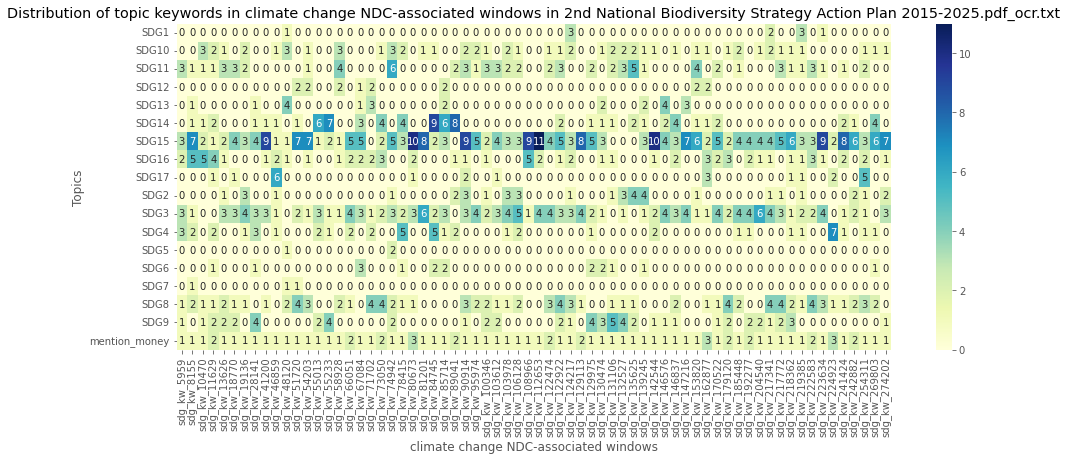

In [34]:
summary_sdg_df_filtered = summary_sdg_df.loc[:, (summary_sdg_df.sum() >= 15)] #filter for windows with at least 15 topic keywords
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df_filtered, #can show all windows with summary_sdg_df
                 annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows with greater than 15 keywords v1.png'))
#plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### Lets see some examples of the text windows that we might think are interesting from their scores in the heatmap:
#### SDG15: "Protect, restore and promote sustainable use of terrestrial ecosystems, sustainably manage forests, combat desertification, and halt and reverse land degradation and halt biodiversity loss"
https://sdgs.un.org/goals/goal15

Below see some example of rendered windows, and just keep in mind that the NDC word/term will always be present at the word index associated with the window, but sometimes it is not properly labelled in the render, probably due to how the span labelling function works in spacy). Also, the number of spans labelled by spacy will always be smaller than the values in the heatmap because no overlapping values are allowed.

In [36]:
indices_for_render = [78415, 81201] 
for idx in indices_for_render: 
    word_i_for_idx = ndc_i_df[ndc_i_df['doc_position_idx_index']==idx]['word_index'][0]
    print("The NDC word for the window is ", [token for token in tokens if token.idx == idx])
    displacy.render(all_labelled_doc[(word_i_for_idx-30):(word_i_for_idx+30)], style = "ent", jupyter = True)

The NDC word for the window is  [development]


The NDC word for the window is  [management]


#### SDG14: "Conserve and sustainably use the oceans, seas and marine resources for sustainable development"
https://sdgs.un.org/goals/goal14

In [37]:
indices_for_render = [89041] #note that system is both a climate change keyword and an early warning keyword
for idx in indices_for_render: 
    word_i_for_idx = ndc_i_df[ndc_i_df['doc_position_idx_index']==idx]['word_index'][0]
    print("The NDC word for the window is ", [token for token in tokens if token.idx == idx])
    displacy.render(all_labelled_doc[(word_i_for_idx-30):(word_i_for_idx+30)], style = "ent", jupyter = True)

The NDC word for the window is  [system]


#### An example of a window with several words from the mention money category among others:

In [38]:
indices_for_render = [34339, 68913, 236176, 237041] 
for idx in indices_for_render: 
    word_i_for_idx = ndc_i_df[ndc_i_df['doc_position_idx_index']==idx]['word_index'][0]
    print("The NDC word for the window is ", [token for token in tokens if token.idx == idx])
    displacy.render(all_labelled_doc[(word_i_for_idx-30):(word_i_for_idx+30)], style = "ent", jupyter = True)

The NDC word for the window is  [development]


The NDC word for the window is  [development]


The NDC word for the window is  [budget]


The NDC word for the window is  [institutional]


### If want to be able to label windows with keyword mentions de novo, can use the below function: 

In [39]:
def label_ndc_sdg_spans_in_windows(keyword_df, doc, topic_column='clasification'):
    """keyword_df is a pandas df, doc is the window text with nlp run on it."""
    matcher = PhraseMatcher(nlp.vocab)
    entity_labels = []
    topics = list(keyword_df[topic_column].value_counts().index)
    for topic in topics:
        entity_labels.append(topic)
        keywords = list(keyword_df[keyword_df[topic_column]==topic]['keyword'])
        #print(keywords)
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(topic, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    return entity_labels, doc

In [40]:
index_list_for_render = [34339, 68913, 236176, 237041] 
for i in index_list_for_render: 
    print(i)
    window_to_label = nlp(return_window_idx(i, tokens, size=window_size)[2])
    entity_labels, labelled_window = label_ndc_sdg_spans_in_windows(sdg_ontology, window_to_label, topic_column='clasification')
    displacy.render(labelled_window, style = "ent", jupyter = True) #use original tokens

34339


68913


236176


237041


### coherence and relevance

In [41]:
coherence_for_frame = summary_sdg_df.sum(axis=1)/len(summary_sdg_df.columns)
coherence_df = coherence_for_frame.to_frame().rename(columns={0:"Topic score"})
coherence_score = coherence_df['Topic score'].sum()
print(coherence_score)
coherence_df

relevance_score = len(ndc_climate_idxs)/len(sentences)
print('The relevance score for %s is' % doc_name , relevance_score)
print('The coherence score for %s is' % doc_name , coherence_score)

10.400462962962962
The relevance score for 2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt is 0.9123065585851142
The coherence score for 2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt is 10.400462962962962


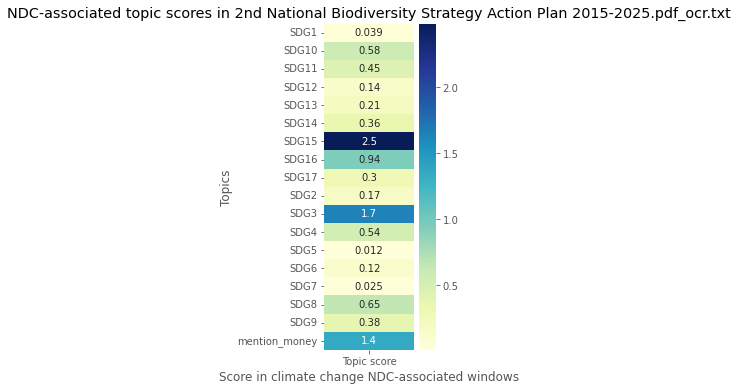

In [42]:
#print a summary of the SDG words found in the windows: 
plt.figure(figsize=(2, 6))
ax = sns.heatmap(coherence_df, 
                 annot=True, #fmt="d", 
                 cmap="YlGnBu")

plt.xlabel("Score in climate change NDC-associated windows")
plt.ylabel("Topics")
title = ("NDC-associated topic scores in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across document normalized by number of windows v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

## Additional functions in spacy that could be useful and worht exploring more

### Parts of speech tagging

In [ ]:
for token in filtered_tokens[:50]:
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))
print('\n')
    
nouns = []
adjectives = []
for token in filtered_tokens:
    if token.pos_ == 'NOUN':
        nouns.append(token)
    if token.pos_ == 'ADJ':
        adjectives.append(token)

print('some nouns spacy called in the document include:', '\n', nouns[:50], '\n')
print('some adjectives spacy called in the document include:', '\n', adjectives[:50])

### Dependency visualization in sentences

In [ ]:
sent_example = nlp("For example, it is estimated that between 9 and 12 million DATE people in impoverished rural areas directly use natural resources such as fuel wood, wild fruits and wooden utensils as a source of energy, food and building material respectively (Shackleton ORG 2004)")
sentence_spans = list(sentences)
sentence_spans[:10]
displacy.render(sentence_spans[80], style="dep", jupyter= True)